In [1]:
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

In [3]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

Data = pd.read_excel('E:/vcdata/data/ALL_investment.xlsx')
city2 = Data['city'].drop_duplicates().values
# data2 = pd.read_excel('E:/文档系列/python 系列/TheData/merge/ALL(1991-2017仅插值).xlsx')
city3 = data['City'].values###得到城市
cityUN=list(set(city3).intersection(set(city2))) ###得到两个城市的交集

In [4]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

In [5]:
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###保存所有的log值，小于0的记录为-1
    p2=[]
    g2=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log10(XI)
    yi=np.log10(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
    if abs(max(sc))>abs(min(sc)):
        Maxsc = abs(max(sc))
    else:
        Maxsc = abs(min(sc))   
    ###按照sc的值进行排序
    scdic = list(zip(sc/Maxsc,City))
    scSort = sorted( scdic)###残差城市排序
    
#     prodic = dict(zip(pro,sc))
#     proSort = sorted( prodic.items(),key = lambda x:x[1],reverse = True)###省作为item会有很多省北过滤掉
    prodic = list(zip(sc/Maxsc,pro))
    proSort = sorted( prodic)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort)

In [6]:
def getCity(s):
    a=list(s.split('|'))
    return(a[1])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省
c=len(province)###一级产业数量
a=list(sns.color_palette("hls", c))
yj_color=dict(zip(province,a))

In [7]:
len(province)

31

In [8]:
######### GDP #############
######################## GDP ########################
###计算相关年份的数据
year=2015
yearvalue=year-2000
sami_GDP0=GuiJI(data,pop,gdp,yearvalue,'pop','GDP')

###城市按照残差排名图
dicsc0=sami_GDP0[8]
scname0=[dicsc0[x][1] for x in range(len(dicsc0))]###城市名
prosc0=sami_GDP0[11]###残差
proname0=[prosc0[x][1] for x in range(len(prosc0))]

x0=np.arange(1,len(city)+1)
y0=[dicsc0[x][0] for x in range(len(dicsc0))]

In [9]:
################### amount ############################
###计算相关年份的数据
sami_investment0=GuiJI(data,pop,investment,yearvalue,'pop','investment')
###城市按照残差排名图
dicscM0=sami_investment0[8]###[sc,cityrank]
scnameM0=[dicscM0[x][1] for x in range(len(dicscM0))]###city name
proscM0=sami_investment0[11]
pronameM0=[proscM0[x][1] for x in range(len(proscM0))]###province name

xM0=np.arange(1,len(scnameM0)+1)
yM0=[dicscM0[x][0] for x in range(len(dicscM0))]

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [10]:
#################### times ############################
###计算相关年份的数据
###城市按照残差排名图
sami_times0=GuiJI(data,pop,inv_times,yearvalue,'pop','times')
dicscT0=sami_times0[8]
scnameT0=[dicscT0[x][1] for x in range(len(dicscT0))]
proscT0=sami_times0[11]
pronameT0=[proscT0[x][1] for x in range(len(proscT0))]

xT0=np.arange(1,len(scnameT0)+1)
yT0=[dicscT0[x][0] for x in range(len(dicscT0))]

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [11]:
### 删选出来有投资的城市，投资次数为1的城市将其残差记为最小值。
sc_GDP0=[] ###保存含有投资的城市的GDP
sc_times0=[] ###保存有投资的城市的投资次数，将次数为1的残差填充为最小值
for c1 in scnameM0:
    for c2 in range(len(scname0)):
        if scname0[c2] == c1:
            sc_GDP0.append(y0[c2])
### 得到投资次数的残差数据
for c1 in scnameM0:
    for c2 in range(len(scnameT0)):
        if scnameT0[c2] == c1:
            sc_times0.append(yT0[c2])

In [12]:
#### 按照残差对GDP进行排序, 不可以使用字典，会过滤掉一些重复数据
prodic_GDP0 = zip(sc_GDP0,pronameM0)###得到省份sc，对其排序
city_GDP0 = zip(sc_GDP0,scnameM0)###得到省份sc，对其排序
proSort_GDP0 = sorted( prodic_GDP0,reverse = True)
citySort_GDP0 = sorted( city_GDP0,reverse = True)

#### 按照残差对投资金额进行排序
prodic_amount0 = zip(yM0,pronameM0)###得到省份sc，对其排序
city_amount0 = zip(yM0,scnameM0)###得到省份sc，对其排序
proSort_amount0 = sorted( prodic_amount0,reverse = True)
citySort_amount0 = sorted( city_amount0,reverse = True)

#### 按照残差对投资次数进行排序
prodic_times0 = zip(sc_times0,pronameM0)###得到省份sc，对其排序
city_times0 = zip(sc_times0,scnameM0)###得到省份sc，对其排序
proSort_times0 = sorted( prodic_times0,reverse = True)
citySort_times0 = sorted( city_times0,reverse = True)

In [13]:
#### 得到城市名、省名、残差
proName_GDP = [proSort_GDP0[x][1] for x in range(len(proSort_GDP0))] ###省名
cityName_GDP = [citySort_GDP0[x][1] for x in range(len(citySort_GDP0))] ###城市名
citySC_GDP = [citySort_GDP0[x][0] for x in range(len(citySort_GDP0))] ###城市sc
#### amount
proName_amount = [proSort_amount0[x][1] for x in range(len(proSort_amount0))] ###省名
cityName_amount = [citySort_amount0[x][1] for x in range(len(citySort_amount0))] ###城市名
citySC_amount = [citySort_amount0[x][0] for x in range(len(citySort_amount0))] ###城市sc
#### times
proName_times = [proSort_times0[x][1] for x in range(len(proSort_times0))] ###省名
cityName_times = [citySort_times0[x][1] for x in range(len(citySort_times0))] ###城市名
citySC_times = [citySort_times0[x][0] for x in range(len(citySort_times0))] ###城市sc

In [14]:
from sklearn import preprocessing
#### scname 城市名，prosc 省的残差，proname 省名
def getAvg(scname,prosc,proname, province,yj_color,name1,name2):###得到省份关于平均sc，并对其进行拟合，得到斜率
    rank1=np.arange(1,len(scname)+1)###排名
    rank = rank1/rank1.max() ###利用rank最大值进行归一化处理
    ###得到每个省的平均sc
    pscSum=[]
    Pnum=[]###记录所有城市的个数
    prank=[]###记录省的排名
    Erank=[]###所有省的关于城市的排名
    Esc=[]###所有省份的关于城市的sc
    for pp in range(len(province)):
        scsum=0###记录一个省的总的sc
        pnum=0###记录省的个数
        pranks=0###排名
        eveRank=[]###每一个省的排名
        eveSC=[]###每一个省的sc
        for jj in range(len(prosc)):
            if proname[jj]==province[pp]:
                scsum+=prosc[jj]
                pnum+=1
                pranks+=rank[jj]
                eveRank.append(rank[jj])
                eveSC.append(prosc[jj])
        pscSum.append(scsum)
        Pnum.append(pnum)
        prank.append(pranks)
        Erank.append(eveRank)
        Esc.append(eveSC)
    
#     plt.figure(figsize=(9,6))
    font2 = {'family' : 'Arial',
        'weight' : 'normal',
        'size' : 20,
        }###设置横纵坐标的字体格式
    plt.xlabel(name1,font2)
#     plt.ylabel(name2,font2)
    plt.ylabel(r'$\xi$'+name2,font2)
    plt.tick_params(labelsize=18) #刻度字体大小13

    avgR=[]###得到所有的平均排名
    avgSC=[]###得到所有平均sc
    ALLstd=[]###得到标准差
    scstd=[]###得到sc的排名
    
    for nn in range(len(Pnum)):
        
        if Pnum[nn]==0:
            avgsc=0
            avgrank=0
        else:
            avgsc=pscSum[nn]/Pnum[nn]###sc的平均值
            avgrank=prank[nn]/Pnum[nn]###排名的平均值

        if avgrank!=0 and avgsc!=0:
            avgrank1 = avgrank
            avgsc1 = avgsc
            avgR.append(avgrank1)
            avgSC.append(avgsc1)
        if len(Erank[nn])>1 and Pnum[nn]!=0:###过滤掉只有一个值的数据
            rank_std = np.std(Erank[nn],ddof=1)###得到标准差
            res_std = np.std(Esc[nn],ddof=1)###得到标准差
            ALLstd.append(rank_std)
            scstd.append(res_std)

        else:
            rank_std=0
            res_std=0
            ALLstd.append(rank_std)
            scstd.append(res_std)
### 得到省的排名和std
    avgrr = avgR###排名   /max(avgR)
    avgssc = avgSC  ###残差
    Erankk = ALLstd  ###排名std   /max(ALLstd)
    Escc = scstd  ###残差std
    
    for nn in range(len(avgrr)):
        if avgrr[nn]!=0 and avgssc[nn]!=0:
            avgrank2 = avgrr[nn]
            avgsc2 = avgssc[nn]
        if len(Erank[nn])>1 and Pnum[nn]!=0:###过滤掉只有一个值的数据
#             rank_std2 = np.std(Erankk[nn],ddof=1)###得到标准差
#             res_std2 = np.std(Escc[nn],ddof=1)###得到标准差
            plt.scatter(avgrank2,avgsc2,s=[120],color=yj_color[province[nn]])
            plt.plot([avgrank2-Erankk[nn],avgrank2+Erankk[nn]],[avgsc2,avgsc2],color=yj_color[province[nn]])
            plt.plot([avgrank2,avgrank2],[avgsc2-Escc[nn],avgsc2+Escc[nn]],color=yj_color[province[nn]])
        else:
            rank_std2=0
            res_std2=0
            plt.scatter(avgrank2,avgsc2,s=[120],color=yj_color[province[nn]])
    
    p0=[1,10]
    Xi=np.array(avgrr)
    Yi=np.array(avgssc)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    y = [k*x+b for x in avgrr]
    k1=round(k, 2)
    plt.plot(avgrr,y,color='black')#,label='slope = {}'.format(k1)
#     plt.scatter(avgrr,avgssc)
    plt.xlim(-0.5,1.5)
    plt.ylim(-1,1.1)
    plt.text(0.65, 0.8, 'slope = {}'.format("%.2f" % k),size=27)


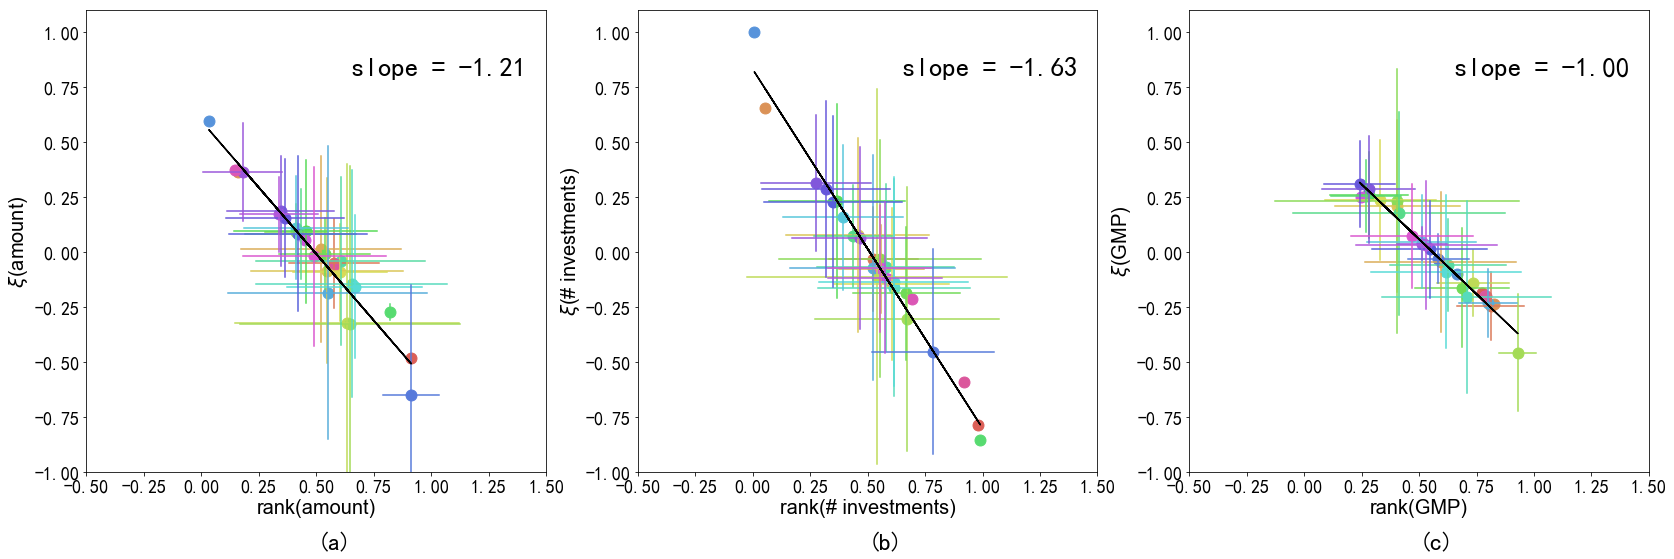

In [17]:
############ 排名总体归一化  rank/len(cityM)###
############## 得到省关于 amount 的箱线图
plt.figure(figsize=(28,8.5))
plt.subplot(131)
getAvg(cityName_amount,citySC_amount,proName_amount, province,yj_color,'rank(amount)','(amount)')
plt.text(0.5,-1.35,'(a)',fontsize=24)
# plt.text(-0.8,1.1,'(a)',fontsize=24)
############## 得到省关于 times 的箱线图
plt.subplot(132)
getAvg(cityName_times,citySC_times,proName_times, province,yj_color,'rank(# investments)','(# investments)')
# plt.text(-0.8,1.1,'(b)',fontsize=24)
plt.text(0.5,-1.35,'(b)',fontsize=24)
############# 得到省关于GDP 的箱线图
plt.subplot(133)
getAvg(cityName_GDP,citySC_GDP,proName_GDP, province,yj_color,'rank(GMP)','(GMP)')
# plt.text(-0.8,1.1,'(c)',fontsize=24)
plt.text(0.5,-1.35,'(c)',fontsize=24)
# plt.tight_layout()
# plt.savefig('E:/vcdata/pic/picSC/Fig2_ghi2.pdf', bbox_inches='tight')
plt.savefig('E:/0论文/2picture/3_3.png',dpi=500, bbox_inches='tight')
# plt.savefig('E:/0论文/e.png',dpi=500, bbox_inches='tight')

Text(-0.8,1.1,'(c)')

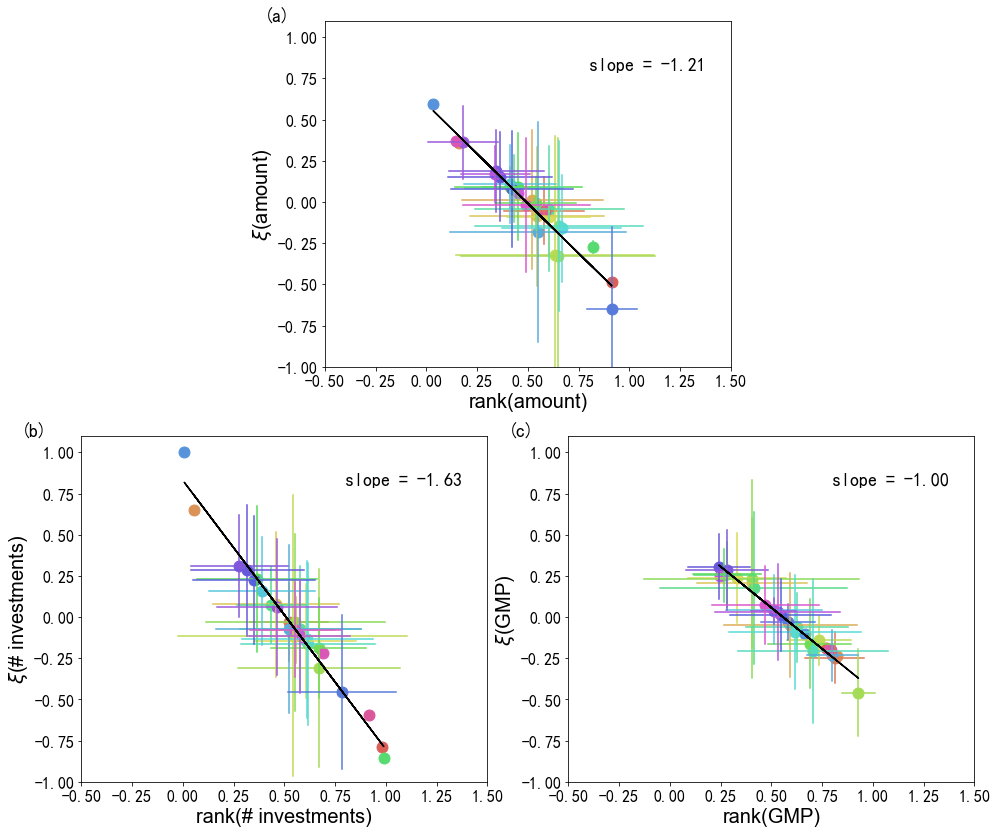

In [42]:
############ 排名总体归一化  rank/len(cityM)###
############## 得到省关于 amount 的箱线图
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16,14))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, 1:3])
getAvg(cityName_amount,citySC_amount,proName_amount, province,yj_color,'rank(amount)','(amount)')
plt.text(-0.8,1.1,'(a)',fontsize=18)

############## 得到省关于 times 的箱线图
ax2 = plt.subplot(gs[1, :2], )
getAvg(cityName_times,citySC_times,proName_times, province,yj_color,'rank(# investments)','(# investments)')
plt.text(-0.8,1.1,'(b)',fontsize=18)
############# 得到省关于GDP 的箱线图
ax3 = plt.subplot(gs[1, 2:])
getAvg(cityName_GDP,citySC_GDP,proName_GDP, province,yj_color,'rank(GMP)','(GMP)')
plt.text(-0.8,1.1,'(c)',fontsize=18)
# plt.tight_layout()
# plt.savefig('E:/0论文/0picture/4_3.png',dpi=500, bbox_inches='tight')